In [27]:
import numpy as np
import pandas as pd

In [28]:
cwru = np.load('CWRU_48k_load_1_CNN_data.npz')

In [29]:
print(cwru.files)

['data', 'labels']


In [30]:

data = cwru['data']
classes = cwru['labels']
print('size of array classes:',classes.shape)
print()
print('size of array data:',data.shape)
print()
print('random classes ',classes)
print()
unique_classes = np.unique(classes)
print('unique labels',unique_classes)

# ENCODING + catogarizing classes acccording to their unique labels  
classes = pd.Categorical(classes, categories=unique_classes).codes
print(classes)

size of array classes: (4600,)

size of array data: (4600, 32, 32)

random classes  ['Ball_007' 'Ball_007' 'Ball_007' ... 'Normal' 'Normal' 'Normal']

unique labels ['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']
[0 0 0 ... 6 6 6]


In [31]:
data[0].shape

(32, 32)

In [32]:
# resizing data dividing it into  segments inorder to apply wavelet transform
data_resized = np.reshape(data, (4600,1024))

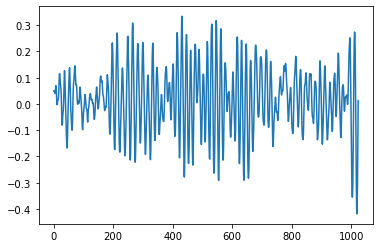

In [33]:
import matplotlib.pylab as plt

plt.plot(data_resized[1])


In [34]:
np.save('resized_cwru_data', data_resized)

In [35]:
from scipy import signal
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pywt

#wavelet_data = np.repeat(np.nan, repeats = 4600 * 32 * 32)
#wavelet_data = wavelet_data.reshape(-1,32,32)

#width = np.arange(1,2049,step = 32 )
#for i in range(data_resized.shape[0]):
#   coeffecients = pywt.cwt(data_resized[i, :],width,"morl")
#   wavelet_data[i,:,:] = tf.reshape(tf.image.resize(coeffecients.reshape((64, 1024, 1)), (32, 32)), (32, 32))



In [36]:
import pywt
import tensorflow as tf

wavelet_data = np.repeat(np.nan, repeats = 4600 * 32 * 32).reshape(-1, 32, 32)
for i in tqdm(range(data_resized.shape[0])):
    segment = data_resized[i, :]
    coefs, _ = pywt.cwt(segment, np.arange(start = 1, stop = 2049, step = 32), "morl")
    wavelet_data[i, :, :] = tf.reshape(tf.image.resize(coefs.reshape((64, 1024, 1)), (32, 32)), (32, 32))

wavelet_data = np.array(wavelet_data)
wavelet_data.shape



100%|██████████| 4600/4600 [16:17<00:00,  4.71it/s]


(4600, 32, 32)

In [37]:
wavelet_data.shape

(4600, 32, 32)

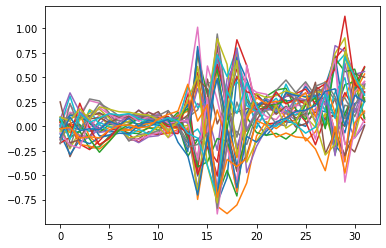

In [38]:
plt.plot(wavelet_data[90])

In [39]:
#Train_data = wavelet_data[0:4000,:,:]
#Train_class = classes[0:4000]
#Validation_data = wavelet_data[4000:4600,:,:]
#Validation_class = classes[4000:4600]


In [40]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



#for cross validation check dividing training data again
data_train, data_test, classes_train, classes_test = train_test_split(wavelet_data,classes, test_size=0.2, random_state=527 , stratify=classes)

#data_train, data_valid, classes_train, classes_valid = train_test_split(data_train,classes_train, test_size=0.2, random_state=125,stratify=classes_train)
print(data_train.shape)
#print(data_valid.shape)
print(classes_train.shape)

(3680, 32, 32)
(3680,)


In [41]:
# reshaping data
data_train = data_train.reshape(-1,32,32,1)
#data_valid = data_valid.reshape(-1,32,32,1)
data_test = data_test.reshape(-1,32,32,1)

from keras.utils import to_categorical
classes_train = to_categorical(classes_train)
classes_test = to_categorical(classes_test)
#classes_valid = to_categorical(classes_valid)

# Shuffling our data
index = np.random.permutation(len(classes_train))
data_train, classes_train = data_train[index], classes_train[index]

print('training data shape: ', data_train.shape)
#print('validation data shape: ', data_valid.shape)
print('testing data shape: ', data_test.shape)
print('training classes shape: ', classes_train.shape)
#print('validation classes shape: ', classes_valid.shape)
print('testing classes shape: ', classes_test.shape)


training data shape:  (3680, 32, 32, 1)
testing data shape:  (920, 32, 32, 1)
training classes shape:  (3680, 10)
testing classes shape:  (920, 10)


In [42]:

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Conv2D, MaxPooling2D, Flatten

In [43]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape = (32,32,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=6, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        36896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

N_Network = model.fit(data_train , classes_train, epochs=30, batch_size=128, validation_data=(data_test, classes_test))  



Epoch 1/30
29/29 [==============================] - 3s 111ms/step - loss: 1.4853 - accuracy: 0.4277 - val_loss: 0.8584 - val_accuracy: 0.7707
Epoch 2/30
29/29 [==============================] - 3s 104ms/step - loss: 0.5276 - accuracy: 0.8277 - val_loss: 0.3652 - val_accuracy: 0.8685
Epoch 3/30
29/29 [==============================] - 3s 102ms/step - loss: 0.2828 - accuracy: 0.8951 - val_loss: 0.2480 - val_accuracy: 0.9261
Epoch 4/30
29/29 [==============================] - 3s 101ms/step - loss: 0.2033 - accuracy: 0.9326 - val_loss: 0.2141 - val_accuracy: 0.9152
Epoch 5/30
29/29 [==============================] - 3s 102ms/step - loss: 0.1413 - accuracy: 0.9557 - val_loss: 0.1321 - val_accuracy: 0.9598
Epoch 6/30
29/29 [==============================] - 3s 102ms/step - loss: 0.1232 - accuracy: 0.9611 - val_loss: 0.1281 - val_accuracy: 0.9620
Epoch 7/30
29/29 [==============================] - 3s 102ms/step - loss: 0.0996 - accuracy: 0.9660 - val_loss: 0.1119 - val_accuracy: 0.9652
Epoch 

In [45]:
import time

start = time.time()
model.evaluate(data_test,classes_test, batch_size = 128, verbose = 0)
end = time.time()
print(end - start)

0.3139204978942871


In [46]:
model.evaluate(data_test,classes_test, batch_size = 128, verbose = 0)


[0.02147258073091507, 0.9923912882804871]

In [47]:
model.save("wavelet.h5")

In [48]:
prediction = model.predict(data_test)
prediction_classes = list([])
for each_prediction in prediction:
    prediction_classes.append(list(each_prediction).index(max(each_prediction)))

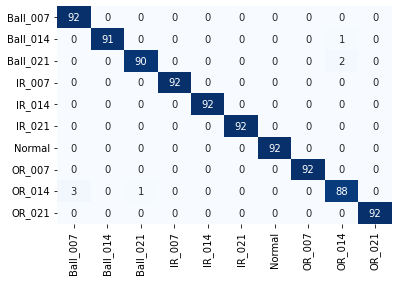

In [49]:
from sklearn.metrics import confusion_matrix
true_classes = np.argmax(classes_test, axis = 1)
matrix = confusion_matrix(true_classes, prediction_classes)

import seaborn as sns
matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = unique_classes,
           yticklabels = unique_classes, cmap = "Blues", cbar = False)
plt.xticks()
plt.show()

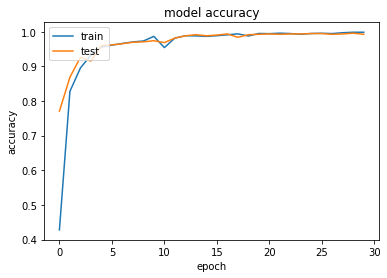

In [50]:
plt.plot(N_Network.history['accuracy'])
plt.plot(N_Network.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

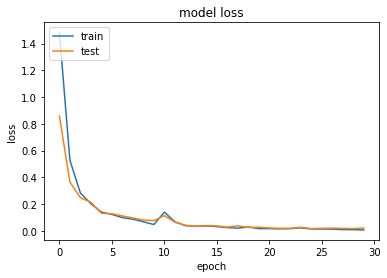

In [51]:
plt.plot(N_Network.history['loss'])
plt.plot(N_Network.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()